# Time series forecasting node memory usage

In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

from parameters import Parameters
from functions import ts_memory, show_plot, plot_ts, univariate_data, ms_val, avg_pred, line_plot

### Import parameters, build and safe df

In [2]:
# import parameters
param = Parameters()
node = 3


# First we create the time-series and save them to a file
# Node to obtain time-series from
node = 3

# Storing the CSV into a DF
results = pd.read_csv("Results.csv")

# Obtain time series of memory usage in node 3
ts = ts_memory(results, node, param)

# Save them to disk
ts.to_pickle('ts.pkl')

100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [01:11<00:00, 1389.23it/s]


In [3]:
ts['memory']

0            0
1            0
2            0
3            0
4            0
         ...  
99995    25500
99996    25500
99997    25500
99998    25500
99999    25500
Name: memory, Length: 100000, dtype: int64

## 1 step forecasting

### Plot and preprocess data

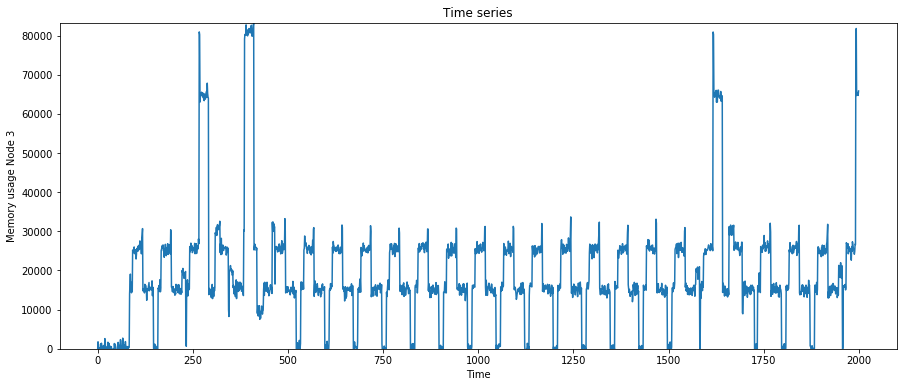

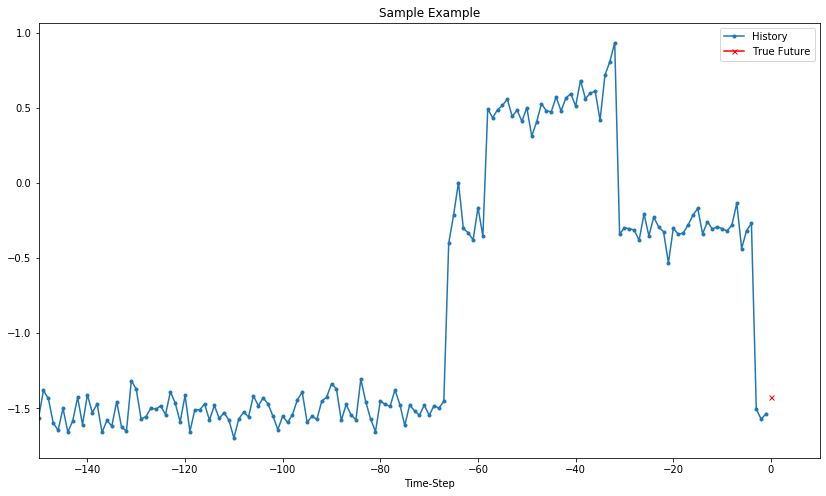

In [24]:
# Use the already saved time-series by loading them from file
ts = pd.read_pickle('ts.pkl')

# Plot time-series
# plot_ts(ts["memory"], node)

# Plot time-series
plot_ts(ts["memory"][:2000], node)

# Set seed for reproducibility
tf.random.set_seed(13)

# Take data
ts_data = ts['memory']
ts_data.index = ts['time']

# We will use 70% percent of data to train
TRAIN_SPLIT = 0.7
TRAIN_SPLIT = int(TRAIN_SPLIT*ts_data.size)

# Normalize data
ts_data_mean = ts_data[:TRAIN_SPLIT].mean()
ts_data_std = ts_data[:TRAIN_SPLIT].std()
ts_data = (ts_data-ts_data_mean) / ts_data_std

# Get the training and validation data and targets
univariate_past_history = 150
univariate_future_target = 1

x_train, y_train = univariate_data(ts_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val, y_val = univariate_data(ts_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

show_plot([x_train[0], y_train[0]], univariate_future_target, 'Sample Example')

### Model

In [7]:
BATCH_SIZE = 100
# BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_univariate = train_univariate.cache().batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(128, input_shape=x_train.shape[-2:]),
    tf.keras.layers.Dense(univariate_future_target)
])

lstm_model.compile(optimizer='adam', loss='mae')

EVALUATION_INTERVAL = 200
EPOCHS = 10

lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 7s 33ms/step - loss: 0.2518 - val_loss: 0.1743
Epoch 2/10
200/200 [==============================] - 4s 22ms/step - loss: 0.1668 - val_loss: 0.1536
Epoch 3/10
200/200 [==============================] - 4s 22ms/step - loss: 0.1619 - val_loss: 0.1545
Epoch 4/10
200/200 [==============================] - 4s 22ms/step - loss: 0.1603 - val_loss: 0.1569
Epoch 5/10
200/200 [==============================] - 4s 22ms/step - loss: 0.1555 - val_loss: 0.1501
Epoch 6/10
200/200 [==============================] - 4s 22ms/step - loss: 0.1600 - val_loss: 0.1662
Epoch 7/10
200/200 [==============================] - 4s 22ms/step - loss: 0.1555 - val_loss: 0.1560
Epoch 8/10
200/200 [==============================] - 4s 22ms/step - loss: 0.1522 - val_loss: 0.1392
Epoch 9/10
200/200 [==============================] - 4s 22ms/step - loss: 0.1460 - val_loss: 0.1410
Epoch 10/10
200/200 [===========================

### Plot results

In [ ]:
for x, y in val_univariate:
    plot = []
    for i in range(len(x)):
        plot.append(show_plot([x[i].numpy(), y[i].numpy(),
                        lstm_model.predict(x)[i]], univariate_future_target, 'Simple LSTM model'))
    

### Predict for val set and plot

In [9]:
y_pred = lstm_model.predict(x_val)

y_val_plot = ms_val(y_val)
y_pred = avg_pred(y_pred)

In [ ]:
line_plot(y_val_plot.flatten(), y_pred.flatten(), 'True', 'Pred')

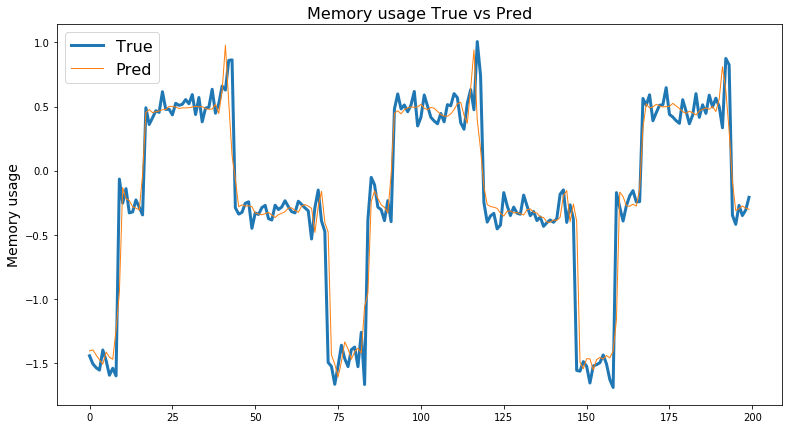

In [11]:
line_plot(y_val_plot.flatten()[800:1000], y_pred.flatten()[800:1000], 'True', 'Pred')

## 5 steps forecasting

### Plot and preprocess data

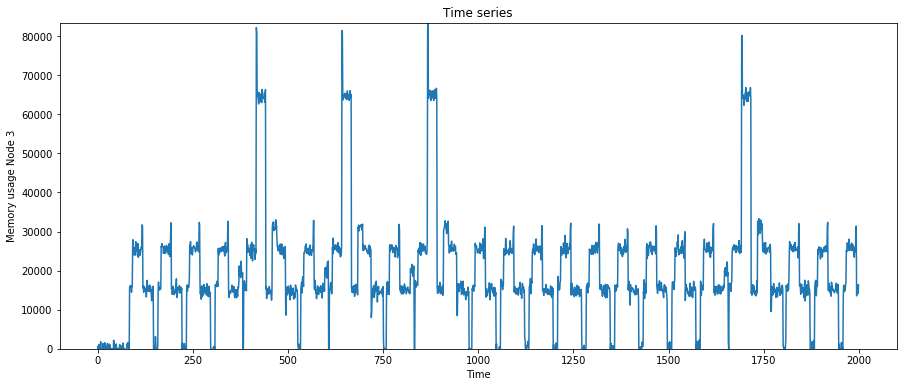

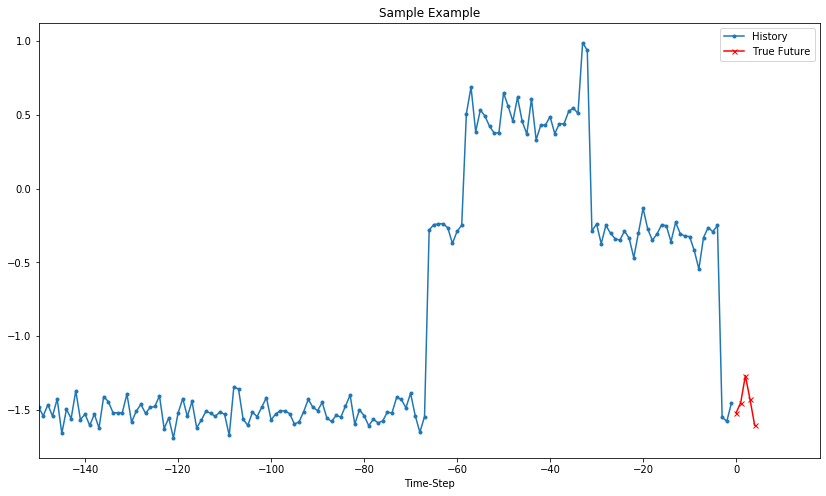

In [12]:
# Use the already saved time-series by loading them from file
ts = pd.read_pickle('ts.pkl')

# Plot time-series
# plot_ts(ts["memory"], node)

# Plot time-series
plot_ts(ts["memory"][:2000], node)

# Set seed for reproducibility
tf.random.set_seed(13)

# Take data
ts_data = ts['memory']
ts_data.index = ts['time']

# We will use 70% percent of data to train
TRAIN_SPLIT = 0.7
TRAIN_SPLIT = int(TRAIN_SPLIT*ts_data.size)

# Normalize data
ts_data_mean = ts_data[:TRAIN_SPLIT].mean()
ts_data_std = ts_data[:TRAIN_SPLIT].std()
ts_data = (ts_data-ts_data_mean) / ts_data_std

# Get the training and validation data and targets
univariate_past_history = 150
univariate_future_target = 5

x_train, y_train = univariate_data(ts_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val, y_val = univariate_data(ts_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

show_plot([x_train[0], y_train[0]], univariate_future_target, 'Sample Example')

### Model

In [13]:
BATCH_SIZE = 100
# BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_univariate = train_univariate.cache().batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(128, input_shape=x_train.shape[-2:]),
    tf.keras.layers.Dense(univariate_future_target)
])

lstm_model.compile(optimizer='adam', loss='mae')

EVALUATION_INTERVAL = 200
EPOCHS = 10

lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 6s 30ms/step - loss: 0.3437 - val_loss: 0.2613
Epoch 2/10
200/200 [==============================] - 4s 22ms/step - loss: 0.2620 - val_loss: 0.2201
Epoch 3/10
200/200 [==============================] - 4s 22ms/step - loss: 0.2198 - val_loss: 0.1773
Epoch 4/10
200/200 [==============================] - 4s 22ms/step - loss: 0.2172 - val_loss: 0.1663
Epoch 5/10
200/200 [==============================] - 4s 22ms/step - loss: 0.1852 - val_loss: 0.1618
Epoch 6/10
200/200 [==============================] - 4s 22ms/step - loss: 0.1973 - val_loss: 0.1790
Epoch 7/10
200/200 [==============================] - 4s 22ms/step - loss: 0.1677 - val_loss: 0.1588
Epoch 8/10
200/200 [==============================] - 4s 22ms/step - loss: 0.1684 - val_loss: 0.1351
Epoch 9/10
200/200 [==============================] - 4s 22ms/step - loss: 0.1751 - val_loss: 0.1486
Epoch 10/10
200/200 [===========================

### Plot results

In [ ]:
for x, y in val_univariate:
    plot = []
    for i in range(len(x)):
        plot.append(show_plot([x[i].numpy(), y[i].numpy(),
                        lstm_model.predict(x)[i]], univariate_future_target, 'Simple LSTM model'))
    

### Predict for val set and plot

In [15]:
y_pred = lstm_model.predict(x_val)

y_val_plot = ms_val(y_val)
y_pred = avg_pred(y_pred)

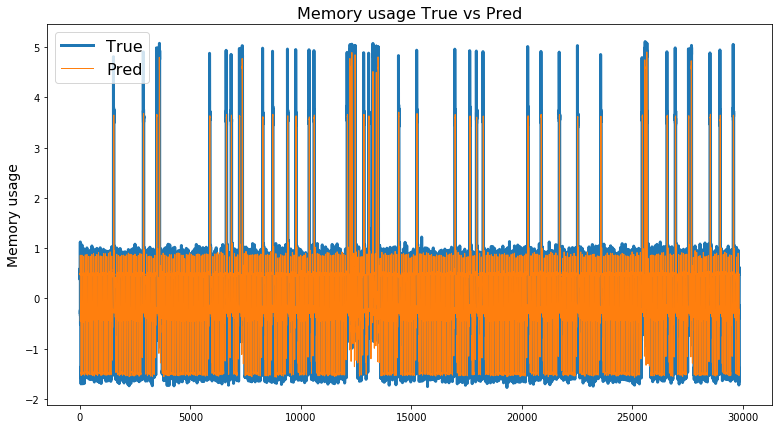

In [16]:
line_plot(y_val_plot.flatten(), y_pred.flatten(), 'True', 'Pred')

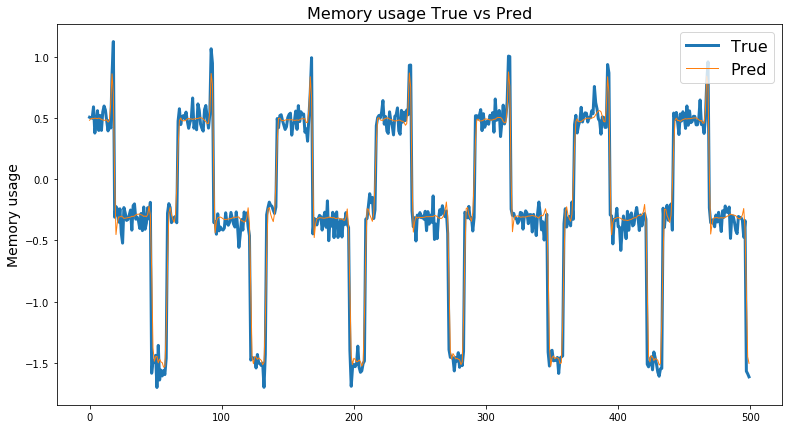

In [17]:
line_plot(y_val_plot.flatten()[:500], y_pred.flatten()[:500], 'True', 'Pred')

## X steps forecasting

### Plot and preprocess data

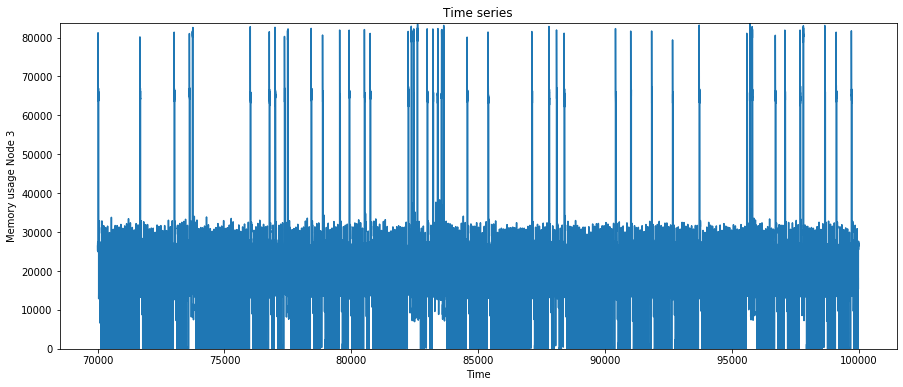

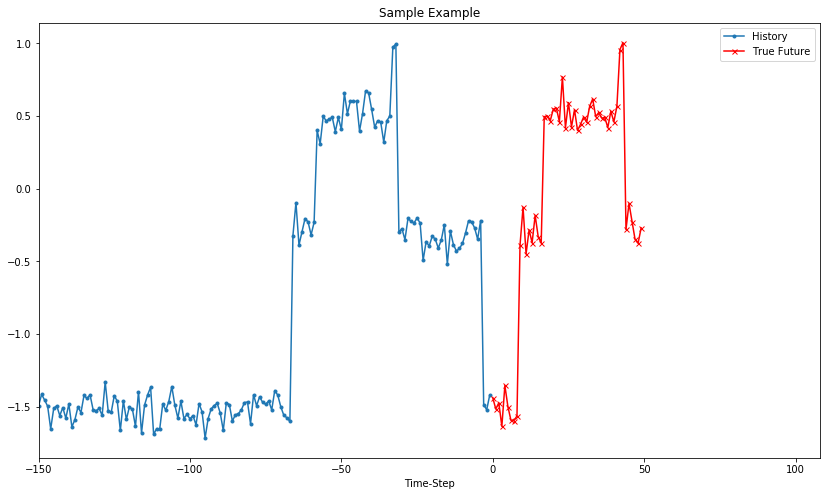

In [18]:
# Use the already saved time-series by loading them from file
ts = pd.read_pickle('ts.pkl')

# Plot time-series
# plot_ts(ts["memory"], node)

# Plot time-series
plot_ts(ts["memory"][70000:], node)

# Set seed for reproducibility
tf.random.set_seed(13)

# Take data
ts_data = ts['memory']
ts_data.index = ts['time']

# We will use 70% percent of data to train
TRAIN_SPLIT = 0.695
TRAIN_SPLIT = int(TRAIN_SPLIT*ts_data.size)

# Normalize data
ts_data_mean = ts_data[:TRAIN_SPLIT].mean()
ts_data_std = ts_data[:TRAIN_SPLIT].std()
ts_data = (ts_data-ts_data_mean) / ts_data_std

# Get the training and validation data and targets
univariate_past_history = 150
univariate_future_target = 50

x_train, y_train = univariate_data(ts_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val, y_val = univariate_data(ts_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

show_plot([x_train[0], y_train[0]], univariate_future_target, 'Sample Example')

### Model

In [19]:
BATCH_SIZE = 100
# BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_univariate = train_univariate.cache().batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(128, input_shape=x_train.shape[-2:]),
    tf.keras.layers.Dense(univariate_future_target)
])

lstm_model.compile(optimizer='adam', loss='mae')

EVALUATION_INTERVAL = 200
EPOCHS = 10

lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 6s 31ms/step - loss: 0.4691 - val_loss: 0.3340
Epoch 2/10
200/200 [==============================] - 4s 22ms/step - loss: 0.3605 - val_loss: 0.2840
Epoch 3/10
200/200 [==============================] - 4s 22ms/step - loss: 0.3140 - val_loss: 0.2742
Epoch 4/10
200/200 [==============================] - 4s 22ms/step - loss: 0.3532 - val_loss: 0.2667
Epoch 5/10
200/200 [==============================] - 4s 22ms/step - loss: 0.2968 - val_loss: 0.2720
Epoch 6/10
200/200 [==============================] - 4s 22ms/step - loss: 0.3564 - val_loss: 0.2965
Epoch 7/10
200/200 [==============================] - 4s 22ms/step - loss: 0.2848 - val_loss: 0.2322
Epoch 8/10
200/200 [==============================] - 4s 22ms/step - loss: 0.2501 - val_loss: 0.3130
Epoch 9/10
200/200 [==============================] - 4s 22ms/step - loss: 0.3279 - val_loss: 0.2427
Epoch 10/10
200/200 [===========================

### Plot results

In [ ]:
for x, y in val_univariate:
    plot = []
    for i in range(len(x)):
        plot.append(show_plot([x[i].numpy(), y[i].numpy(),
                        lstm_model.predict(x)[i]], univariate_future_target, 'Memory usage True vs pred'))
    

### Predict for val set and plot

In [22]:
y_pred = lstm_model.predict(x_val)

y_val_plot = ms_val(y_val)
y_pred = avg_pred(y_pred)

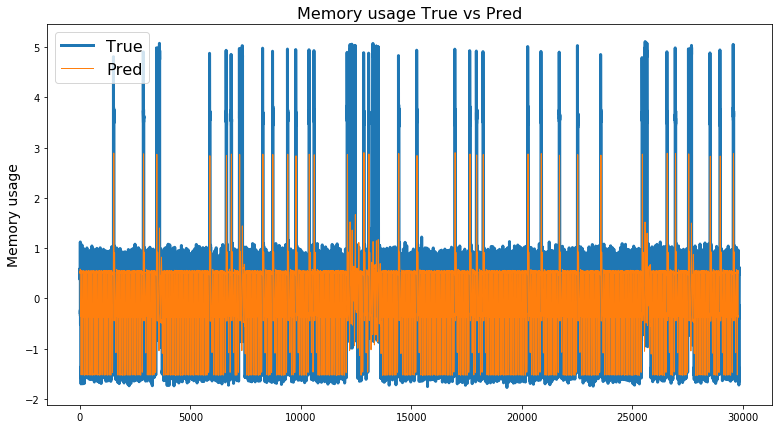

In [23]:
line_plot(y_val_plot.flatten(), y_pred.flatten(), 'True', 'Pred')

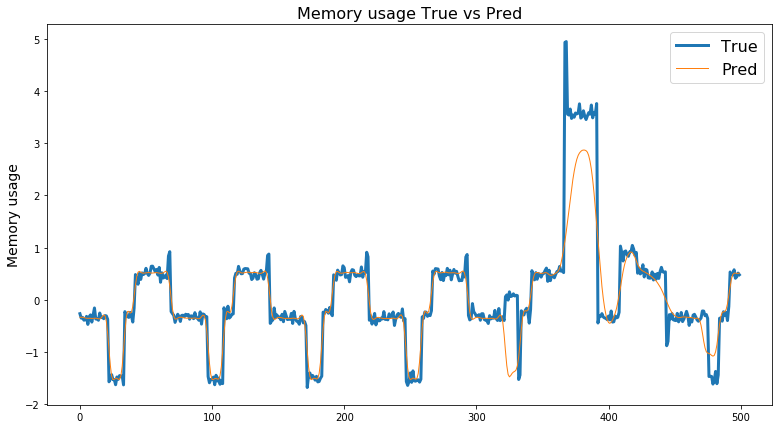

In [24]:
line_plot(y_val_plot.flatten()[10000:10500], y_pred.flatten()[10000:10500], 'True', 'Pred')